<a href="https://colab.research.google.com/github/AhmedSarsour/DeepLearning/blob/main/FacialEmotionRecognitionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the needed libraries.
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json,load_model
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np


In [2]:
#mounting the drive into our google drive folder as the dataset csv file is there.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
# Recommended path: 'deep_perception/assignments/assignment1/'
FOLDERNAME = 'deep_perception/project/'
DATASETFOLDER = 'data_set'

# load data using "np.genfromtxt"
%cd drive/My\ Drive
%cp -r $FOLDERNAME/$DATASETFOLDER ../../
%cd ../../
dataPath = f"{DATASETFOLDER}/fer2020.csv"


Mounted at /content/drive
/content/drive/My Drive
/content


In [3]:
#reading the data csv file from the mounted drive.
data = pd.read_csv(dataPath)

In [9]:
#setting the labels and distributing the data and then again converting them to files
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
training_data = data.iloc[:28709,:]
validation_data = data.iloc[28709:(28709 + 3589), :]
testing_data =  data.iloc[(28709 + 3589):,:]
#converting them back to csv files
training_data.to_csv('Training_Data.csv',index= False)
validation_data.to_csv('Validation_Data.csv', index= False)
testing_data.to_csv('Testing_Data.csv', index= False)

In [11]:
# defining a function to extract features
def get_features(filename):
  X,Y = [],[]
  #the first line is headers only.
  headers = True
  for line in open(filename):
    #ignoring the first line (headers)
    if headers:
      headers = False
    else:
      row = line.split(',')
      X.append([int(feature) for feature in row[1].split()])
      Y.append(int(row[0]))
      
  X,Y = np.array(X)/255.0, np.array(Y)

  return (X,Y)

In [ ]:
# reading from the csv files back to variable(easier method than using pandas)
train_data = pd.read_csv('Training_Data.csv')
val_data = pd.read_csv('Validation_Data.csv')
test_data = pd.read_csv('Testing_Data.csv')


In [21]:
train_file_name = 'Training_Data.csv'
val_file_name = 'Validation_Data.csv'
test_file_name = 'Testing_Data.csv'
#extracting the features of the data set.
train_X, train_Y = get_features(train_file_name)
val_X, val_Y = get_features(val_file_name)
test_X, test_Y = get_features(test_file_name)
#converting to numpy arrays.
train_X = np.array(train_X,'float32')
train_Y = np.array(train_Y,'float32')
val_X = np.array(val_X,'float32')
val_Y = np.array(val_Y,'float32')
test_X = np.array(test_X,'float32')
test_Y = np.array(test_Y,'float32')
num_class = len(set(train_Y))


In [22]:
#setting up the data in the required format
# N= training examples, D= Dimensions
N, D = train_X.shape
val_n,val_d = val_X.shape
test_n, test_d = test_X.shape
train_X = train_X.reshape(N, 48, 48, 1)
val_X = val_X.reshape(val_n, 48, 48, 1)
test_X = test_X.reshape(test_n,48,48,1)


In [25]:
Y_train = to_categorical(train_Y, num_classes=num_class)
Y_val   = to_categorical(val_Y, num_classes=num_class)
Y_test  = to_categorical(test_Y, num_classes=num_class)
Y_test.shape

(3589, 7)

In [26]:
#setting up the labels.
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))

[0 1 2 3 4 5 6]


In [27]:
#importing a plot function,
import matplotlib.pyplot as plt
def plot(dataH):
  acc = dataH.history['accuracy']
  val_acc = dataH.history['val_accuracy']
  loss = dataH.history['loss']
  val_loss = dataH.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.ylabel('Acc')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()


In [35]:
#a function to display the percentage of the emotion prediction probablities.
def emotion_analysis(emotion_preds):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotion_preds, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.title('emotion')
    plt.ylabel('percentage')
    plt.show()

In [43]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def display_predictions_models(img_file,model_1,model_2):
  img = image.load_img(img_file, grayscale=True, target_size=(48, 48))
  show_img=image.load_img(img_file, grayscale=False, target_size=(100, 100))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255
  custom_1 = model_1.predict(x)
  #print(custom_1[0])
  custom_2 = model_2.predict(x)
  #print(custom_2[0])
  
  m=0.000000000000000000001
  a=(custom_1[0] + custom_2[0])/2
  emotion_analysis(a)
  
  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);

  plt.gray()
  plt.imshow(show_img)
  plt.show()

  for i in range(0,len(a)):
      if a[i]>m:
          m=a[i]
          ind=i
          
  print('Expression Prediction:',objects[ind])


In [28]:
#displaying an image prediction & analysis for visual testing
def display_predictions(img_file,model):
  #loading the image.
  img = image.load_img(img_file, grayscale=True, target_size=(48, 48))
  show_img=image.load_img(img_file, grayscale=False, target_size=(100, 100))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x /= 255
  #getting the prediction's probabilities of the model
  custom = model.predict(x)
  #printing the percentange values of each prediction-emotion.
  emotion_analysis(custom[0])
  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);
  plt.gray()
  plt.imshow(show_img)
  plt.show()
  m = -1
  pred = custom[0]
  #getting the index of the emotion object.
  for i in range(0,len(pred)):
      if pred[i] > m:
          m = pred[i]
          ind=i
  #pasting the answer.       
  print('Expression Prediction:',objects[ind])

In [29]:
#the 2nd model.
def base_model_2():
    model = Sequential()
    input_shape = (48,48,1)
    #1st convolution layer
    model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    #2nd convolution layer
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #3rd convolution layer
    model.add(Conv2D(512, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #output
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    my_optimiser = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=my_optimiser)
    
    return model

In [30]:
model_2 = base_model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 512)       1

Epoch 1/14
449/449 [==============================] - 54s 45ms/step - loss: 1.7432 - accuracy: 0.3316 - val_loss: 1.6076 - val_accuracy: 0.3672
Epoch 2/14
449/449 [==============================] - 20s 44ms/step - loss: 1.2619 - accuracy: 0.5200 - val_loss: 1.3250 - val_accuracy: 0.4954
Epoch 3/14
449/449 [==============================] - 20s 44ms/step - loss: 1.0735 - accuracy: 0.5986 - val_loss: 1.2594 - val_accuracy: 0.5196
Epoch 4/14
449/449 [==============================] - 20s 45ms/step - loss: 0.9037 - accuracy: 0.6728 - val_loss: 1.2633 - val_accuracy: 0.5575
Epoch 5/14
449/449 [==============================] - 20s 45ms/step - loss: 0.7013 - accuracy: 0.7535 - val_loss: 1.3650 - val_accuracy: 0.5469
Epoch 6/14
449/449 [==============================] - 20s 45ms/step - loss: 0.5147 - accuracy: 0.8269 - val_loss: 1.3251 - val_accuracy: 0.5692
Epoch 7/14
449/449 [==============================] - 20s 45ms/step - loss: 0.3656 - accuracy: 0.8788 - val_loss: 1.8649 - val_accuracy:

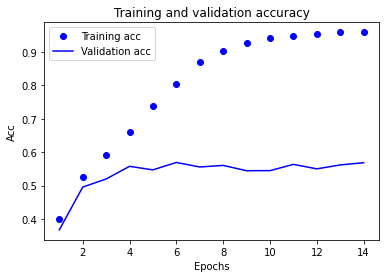

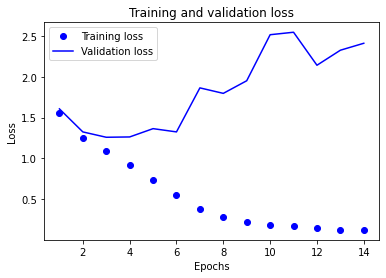

In [31]:
history_2 = model_2.fit(train_X,     
            Y_train, 
            batch_size=64, 
            epochs=14, 
            verbose=1, 
            validation_data=(val_X,Y_val),
            shuffle=True,
            )
plot(history_2)            


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


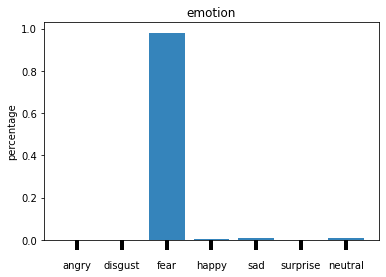

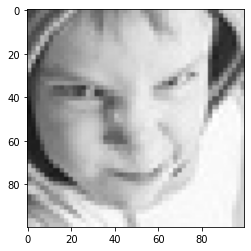

Expression Prediction: fear


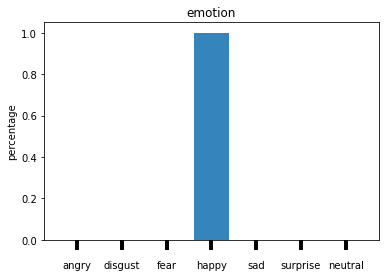

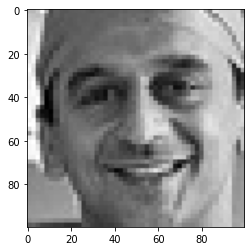

Expression Prediction: happy


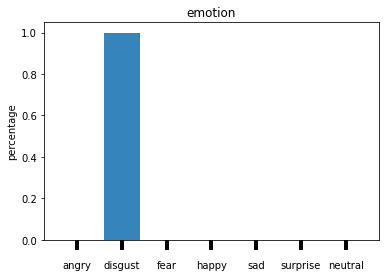

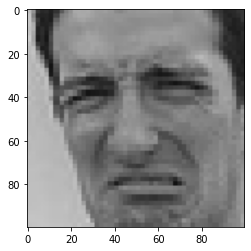

Expression Prediction: disgust


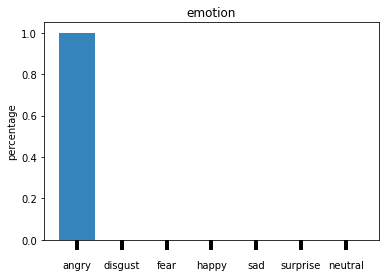

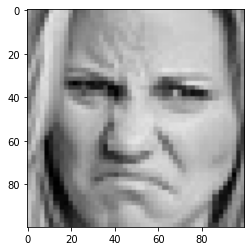

Expression Prediction: angry


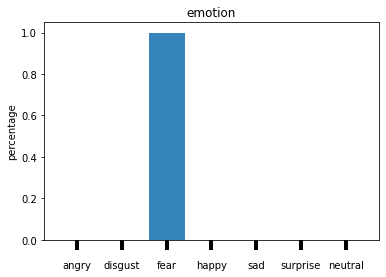

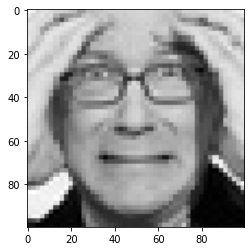

Expression Prediction: fear


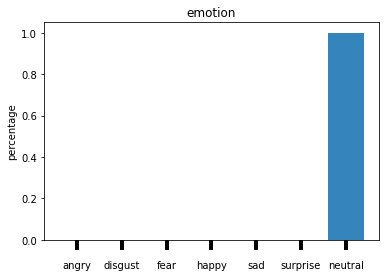

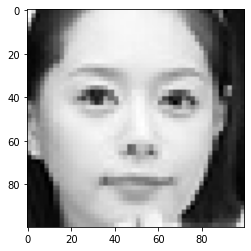

Expression Prediction: neutral


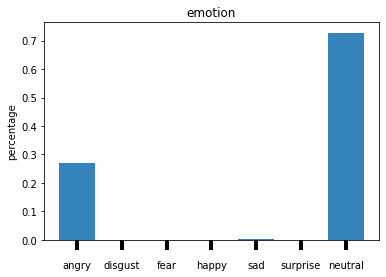

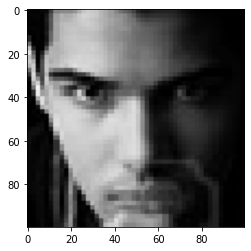

Expression Prediction: neutral


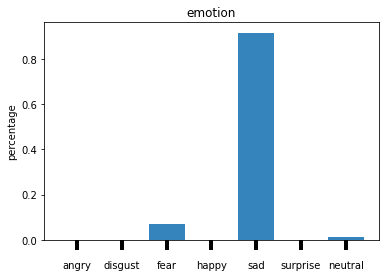

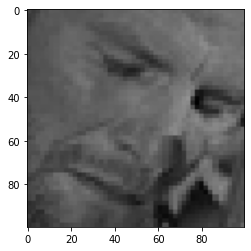

Expression Prediction: sad


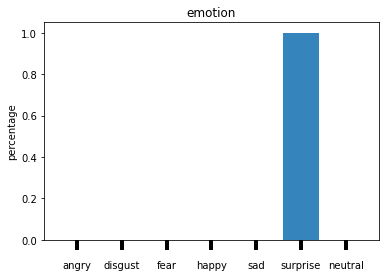

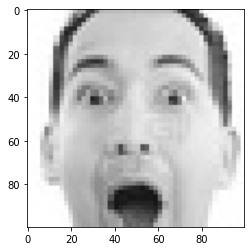

Expression Prediction: surprise


In [36]:
for img in ['angry-1.jpg','happy-2.jpg','disgust-1.jpg','disgust-2.jpg','fear-1.jpg','neutral-1.jpg','neutral-2.jpg','sad-2.jpg','surprise-1.jpg']:
  display_predictions(img,model_2)

In [37]:
def modelOne():
    model = Sequential()
    input_shape = (48,48,1)
    #1st convolution layer

    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    #2nd convolution layer
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))


    my_optimiser = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=my_optimiser)
    
    return model

In [38]:
model_1 = modelOne()
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)      

In [39]:
history = model_1.fit(train_X,     
            Y_train, 
            batch_size=64, 
            epochs=14, 
            verbose=1, 
            validation_data=(val_X,Y_val),
            shuffle=True,
            )

Epoch 1/14
449/449 [==============================] - 9s 18ms/step - loss: 1.8569 - accuracy: 0.2777 - val_loss: 1.6830 - val_accuracy: 0.3374
Epoch 2/14
449/449 [==============================] - 8s 17ms/step - loss: 1.5189 - accuracy: 0.4126 - val_loss: 1.4214 - val_accuracy: 0.4575
Epoch 3/14
449/449 [==============================] - 8s 17ms/step - loss: 1.3776 - accuracy: 0.4673 - val_loss: 1.2987 - val_accuracy: 0.5085
Epoch 4/14
449/449 [==============================] - 8s 17ms/step - loss: 1.2867 - accuracy: 0.5097 - val_loss: 1.2396 - val_accuracy: 0.5191
Epoch 5/14
449/449 [==============================] - 8s 17ms/step - loss: 1.2300 - accuracy: 0.5308 - val_loss: 1.2280 - val_accuracy: 0.5238
Epoch 6/14
449/449 [==============================] - 8s 17ms/step - loss: 1.1869 - accuracy: 0.5491 - val_loss: 1.1800 - val_accuracy: 0.5525
Epoch 7/14
449/449 [==============================] - 8s 17ms/step - loss: 1.1494 - accuracy: 0.5656 - val_loss: 1.1725 - val_accuracy: 0.5681

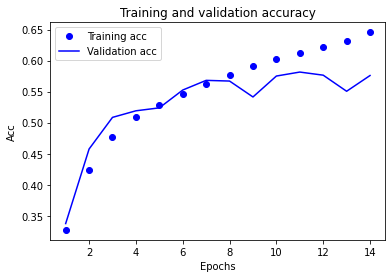

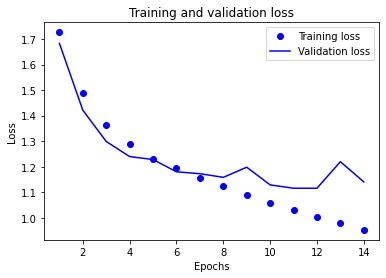

In [40]:
# Lets plot the graph and see what it tell us
plot(history)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


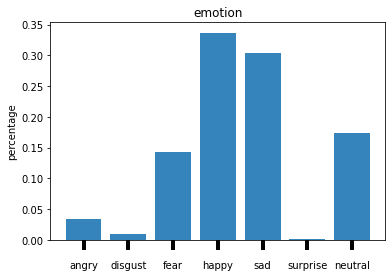

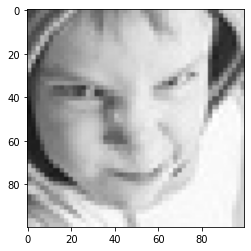

Expression Prediction: happy


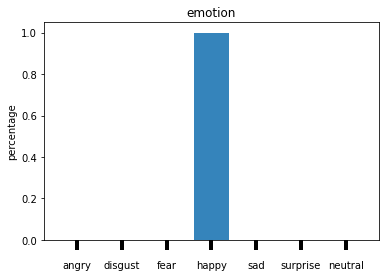

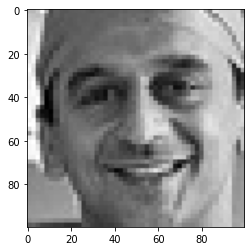

Expression Prediction: happy


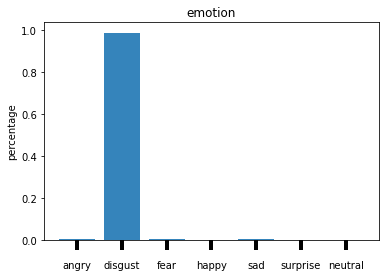

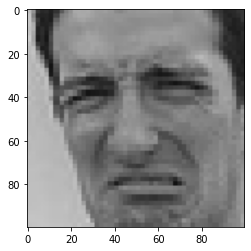

Expression Prediction: disgust


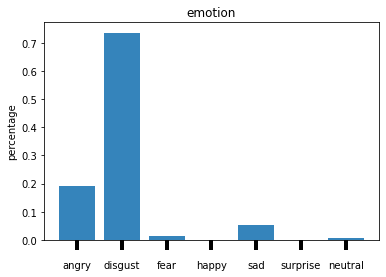

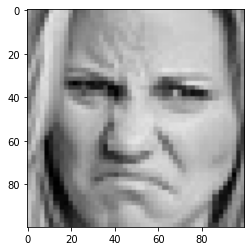

Expression Prediction: disgust


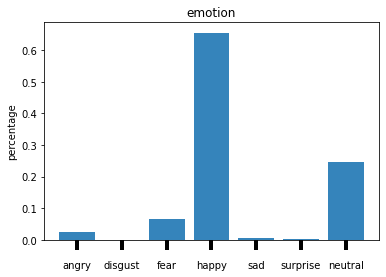

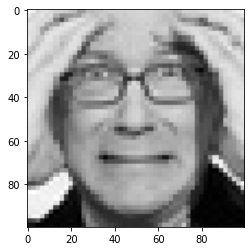

Expression Prediction: happy


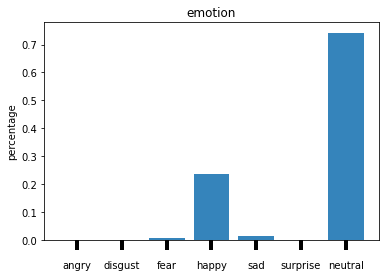

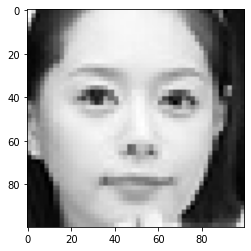

Expression Prediction: neutral


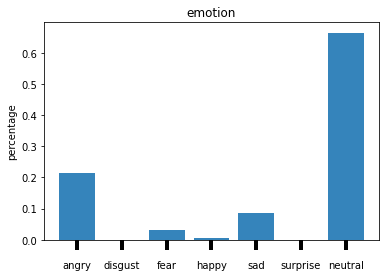

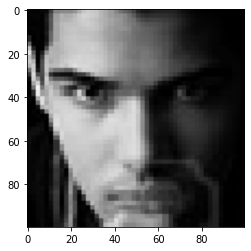

Expression Prediction: neutral


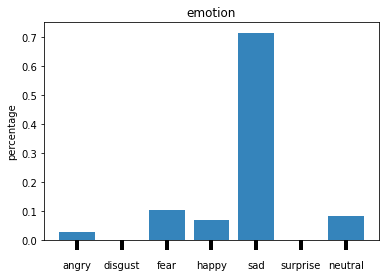

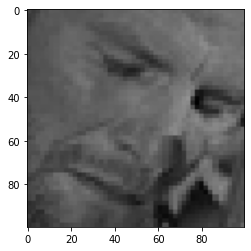

Expression Prediction: sad


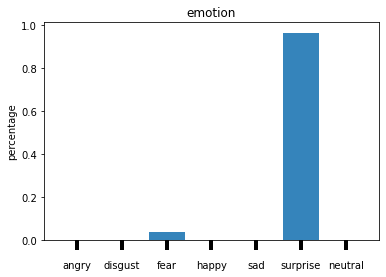

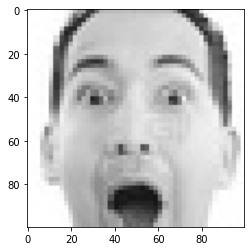

Expression Prediction: surprise


In [41]:
for img in ['angry-1.jpg','happy-2.jpg','disgust-1.jpg','disgust-2.jpg','fear-1.jpg','neutral-1.jpg','neutral-2.jpg','sad-2.jpg','surprise-1.jpg']:
  display_predictions(img,model_1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


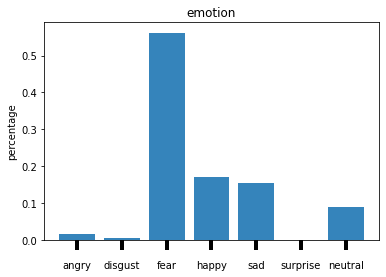

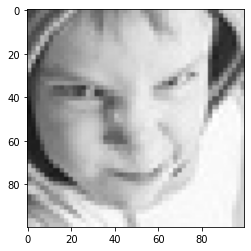

Expression Prediction: fear


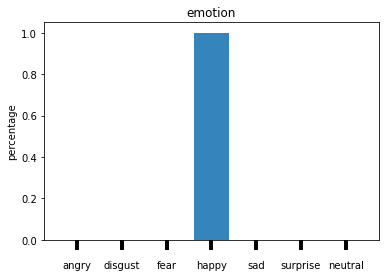

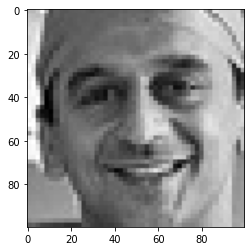

Expression Prediction: happy


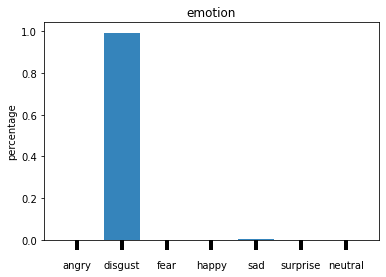

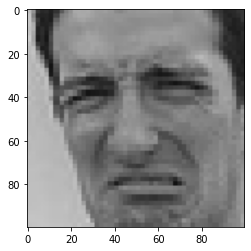

Expression Prediction: disgust


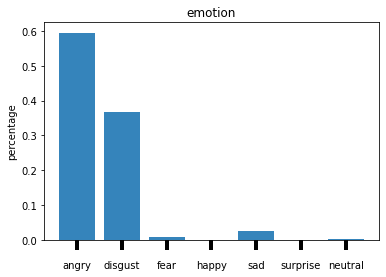

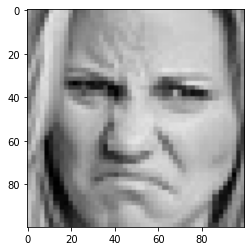

Expression Prediction: angry


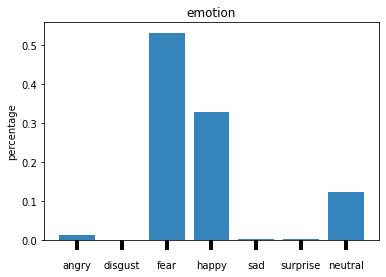

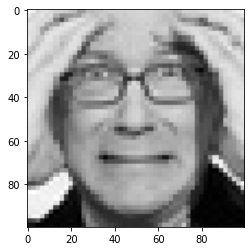

Expression Prediction: fear


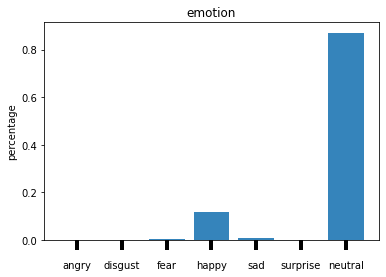

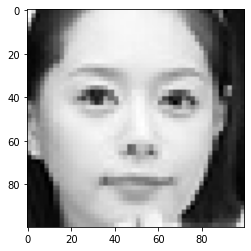

Expression Prediction: neutral


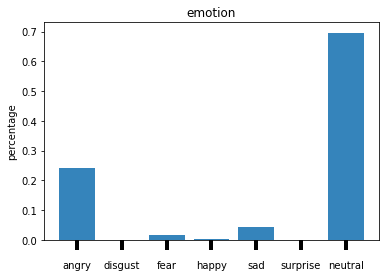

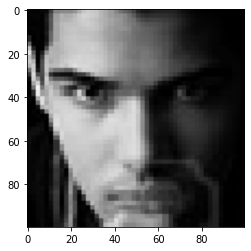

Expression Prediction: neutral


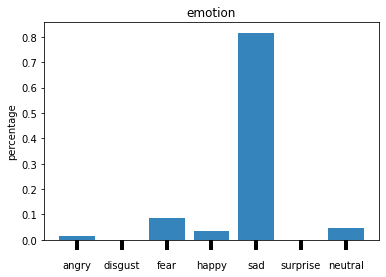

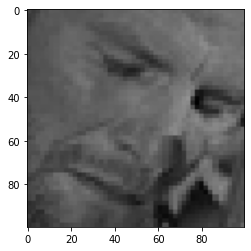

Expression Prediction: sad


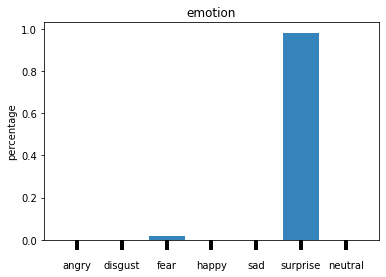

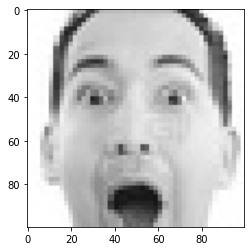

Expression Prediction: surprise


In [44]:
for img in ['angry-1.jpg','happy-2.jpg','disgust-1.jpg','disgust-2.jpg','fear-1.jpg','neutral-1.jpg','neutral-2.jpg','sad-2.jpg','surprise-1.jpg']:
  display_predictions_models(img,model_1,model_2)

In [60]:
#creating a helper function to calculate the precision of the test dataset
from sklearn.metrics import accuracy_score
def calc_acc(model, sample, sample_label):
  preds_sample = model.predict(sample)
  #print(preds_sample)
  preds =[]
  for pred in preds_sample:
    preds.append(get_emotion_index(pred))
  return accuracy_score(sample_label,preds)

In [50]:
#helper function to get the index of the highest emotion probability.
def get_emotion_index(pred_probs):
  m = -1
  for i in range(0,len(pred_probs)):
    if pred_probs[i] > m:
      m = pred_probs[i]
      ind = i
  return ind;

In [ ]:
#the hybrid model mechanism, accepting two models.
class hybrid_model:
  def __init__(self, model_1, model_2):
    self.model_1 = model_1
    self.model_2 = model_2

  def predict(self,sample):
    lst_samples = []
    preds_mod1 = self.model_1.predict(sample)
    preds_mod2 = self.model_2.predict(sample)
    hybrid_preds = []
    for pred_1,pred_2 in zip(preds_mod1, preds_mod2):
      hybrid_pred = [max(h1,h2) for h1,h2 in zip(pred_1,pred_2)]
      hybrid_preds.append(hybrid_pred)
    return hybrid_preds

In [ ]:
hybrid_m = hybrid_model(model_1, model_2)


In [57]:
print(calc_acc(model_1, test_X, test_Y))

0.5814990247979939


In [58]:
print(calc_acc(model_2, test_X, test_Y))

0.5753691836166063


In [59]:
print(calc_acc(hybrid_m, test_X, test_Y))

0.5895792699916411
